## Fig 6A: tax-4/N2 and osm-9/N2 confidence interval plots
<p> The following code will generate plots of the confidence intervals for tax-4/N2 (DMSO and H2O) and osm-9/N2 (DMSO and water)</p>

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.collections import EllipseCollection
from matplotlib.patches import Ellipse
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import pandas as pd
import numpy as np
from math import pi

#### Reading in and cleaning up the datasets
<p> When we are generating this plot we want to order the mutant data according to the N2 response. This helps us to visualize the change in response, if any.</p>

In [13]:
# When reading in the .csv datasets, use this list to retain only the values we care to plot
subset = ['control', 'test', 'test_N', 'difference', 'bca_low', 'bca_high']

In [14]:
#Generating a function that subsets the data for a single 'control' condition
def subset_ref_comp(df, ref):
    dat = df.loc[df['control'] == ref]
    dat =dat.sort_values('difference')
    #Two compounds accidently made it into the mutant screen that should have been excluded due to a sorting error
    dat = dat.loc[(dat['test'] != '2-Nonylquinolin-4(1H)-one') & (dat['test'] != 'Rosmarinic acid')]
    dat = dat.reset_index(drop=True)
    return dat


In [43]:
#Reading all relevant datasets
N2dat = pd.read_csv('D:/_2021_08_screen/S1fu/N2_allrefs.csv', usecols=subset)
CXdat = pd.read_csv('D:/_2021_08_screen/S1fu/cx10_allrefs.csv', usecols=subset)
PRdat = pd.read_csv('D:/_2021_08_screen/S1fu/PR678_allrefs.csv', usecols=subset)

In [59]:
#Generating a function that subsets the data for a single 'control' condition. When the confidence intervals are generated
#the control condition is omitted from the 'test' column and thus needs to be placed back into the df so it's not missing
#in the plot

def data_to_plot(strain, ref, df):
    data = subset_ref_comp(df, ref)
    data = data.loc[data['control']== ref]
    data = data.sort_values('difference')
    data = data.reset_index(drop=True)

    if ref == 'DMSO':
        not_missing = 'H2O'
        missing_index = data.index[data['test'] == not_missing].values[0]
    else:
        not_missing = 'DMSO'
        missing_index = (data.index[data['test'] == not_missing].values[0])+1
        
    
    line = pd.DataFrame({"control": ref , "test": ref, 'test_N':"NaN", 
                         "difference":"NaN", "bca_low":"NaN", "bca_high":"NaN"}, index=[missing_index])
    all_data = pd.concat([data.iloc[:missing_index], line, data.iloc[missing_index:]]).reset_index(drop=True)
    return all_data


#### Generating vertical line plots to visualize the difference in response between N2 and mutant strains for both DMSO and water conditions

In [72]:
# A verbose plotting function. 
# When calling the function be sure to enter the arguments in the correct order:
#1. mut_df : A dataframe containing the specific mutant strain data
#2. wt_df: A dataframe containing the N2 data
#3. control: The 'control'/null reference condition that the test condition confidence intervals were computed against?
#4. mut: Name of the mutant strain
#5: wt: Wild type strain, usually going to be N2
#6. ordr: A list of the desired compound order.
#7. low_lim, up_lim: upper and lower limits of the x-axis passed as integers


def mdiff_plot(mut_df, wt_df, control, mut, wt, ordr, low_lim, up_lim):
    positions = list(range(0, len(ordr)))
    ref_dat1 = mut_df.loc[mut_df['control']==control]
    ref_dat1 = ref_dat1.set_index('test')
    
    reordered1 = ref_dat1.reindex(ordr)
    reordered1 = reordered1.reset_index()
    
    lines1 = []
    for index, row in reordered1.iterrows():
        line = ((row['bca_low'], index), (row['bca_high'], index))
        lines1.append(line)
    
    ref_dat2 = wt_df.loc[wt_df['control']==control]
    ref_dat2 = ref_dat2.set_index('test')
    
    reordered2 = ref_dat2.reindex(ordr)
    reordered2 = reordered2.reset_index()
    
    lines2 = []
    for index, row in reordered2.iterrows():
        line = ((row['bca_low'], index), (row['bca_high'], index))
        lines2.append(line)
    
    ytick_labels = list(reordered1['test'])
    
    mdiffs1 = list(reordered1['difference'])
    mdiffs2 = list(reordered2['difference'])
    
    fig, ax = plt.subplots(figsize=(5,10)) 

    hln_coll1 = mpl.collections.LineCollection(lines1, colors='green', linewidths = .7)
    hln_coll2 = mpl.collections.LineCollection(lines2, colors='dimgrey', linewidths = .7)
    ax = plt.gca()
    
    x_positions = list(np.arange(low_lim, up_lim, 5))
    
    plt.yticks(positions, ytick_labels )
    plt.xticks(x_positions, x_positions)

    ax.xaxis.set_ticks_position('both')
    ax.add_collection(hln_coll1)
    ax.add_collection(hln_coll2)
    ax.scatter(mdiffs1, positions, s=8, c='black')
    ax.scatter(mdiffs2, positions, s=8, c='black')
    ax.tick_params(axis='both', tickdir='in')
    plt.axvline(0, ls='--', c='steelblue')
    ax.set_xlim(low_lim, (up_lim-5))

    ax.set_ylim(-1, len(comp_ord))
    plt.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('D:/NP_manuscript/figs/'+ mut + wt + '_' + control + '_mdiffPlot.svg')


#### We are using the sorted N2 mean differences (calculated for the 95% confidence intervals) for all testing conditions relative to DMSO. This list will be passed to the function call below.

In [73]:
N2DMSO = data_to_plot('N2', 'DMSO', N2dat)
comp_ord= N2DMSO['test']

#### Looping through the mutant strains and control conditions to programatically generate our plots

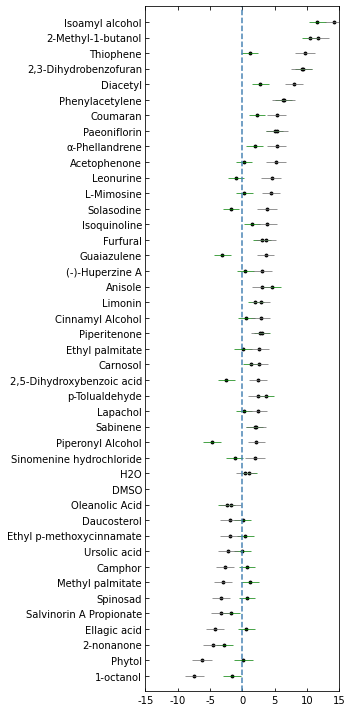

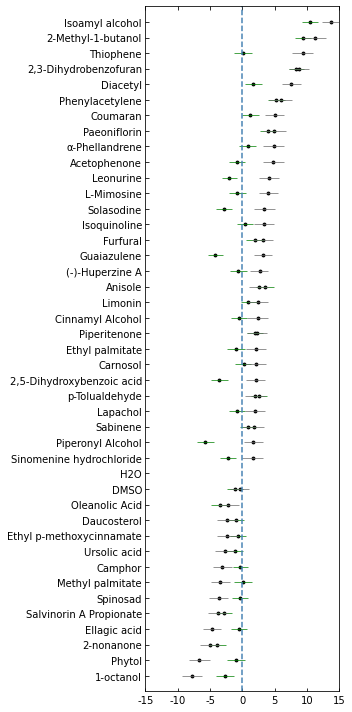

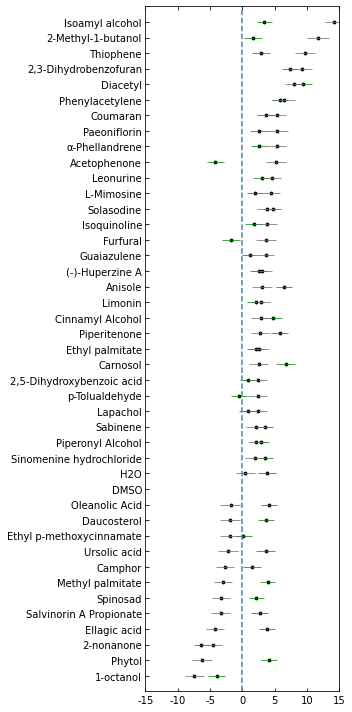

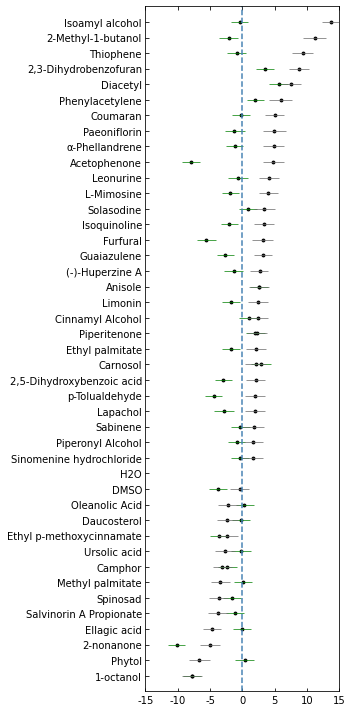

In [74]:
strains = ['CX10', 'PR678']
comps = ['DMSO', 'H2O']

for i in strains:
    if i == 'CX10':
        mutant_df = CXdat
    elif i == 'PR678':
        mutant_df = PRdat
        
    for j in comps:
        mutant_dat = data_to_plot(i, j, mutant_df)
        
        if j == 'DMSO':
            N2_dat = data_to_plot('N2', j , N2dat)
        elif j == 'H2O':
            N2_dat = data_to_plot('N2', j , N2dat)
   
        mdiff_plot(mutant_dat, N2_dat, j, 'N2', i, comp_ord, -15, 20)